In [1]:
# notebooks/01_data_exploration.ipynb
"""
# ADIA Lab Structural Break Challenge - Data Exploration

This notebook explores the structural break detection dataset to understand:
1. Data structure and format
2. Statistical properties of time series
3. Characteristics of structural breaks
4. Feature engineering ideas
"""

'\n# ADIA Lab Structural Break Challenge - Data Exploration\n\nThis notebook explores the structural break detection dataset to understand:\n1. Data structure and format\n2. Statistical properties of time series\n3. Characteristics of structural breaks\n4. Feature engineering ideas\n'

1. Setup and Data Loading

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Import our data loader
import sys
sys.path.append('..')
from src.data.dataLoader import StructuralBreakDataLoader

2. Load and Inspect Data

In [3]:
# Initialize data loader
loader = StructuralBreakDataLoader(data_dir="../data")

# Load data (set use_crunch=True when using in actual notebook with crunch)
X_train, y_train, X_test = loader.load_data(use_crunch=False)

print("Data shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")

INFO:src.data.dataLoader:Data loaded successfully from local files


Data shapes:
X_train: (23715734, 2)
y_train: (10001,)
X_test: (247618, 2)


In [4]:
# Examine data structure
print("\nX_train structure:")
print(X_train.head(20))

print("\n\nFirst few labels:")
print(y_train.head(10))


X_train structure:
            value  period
id time                  
0  0    -0.005564       0
   1     0.003705       0
   2     0.013164       0
   3     0.007151       0
   4    -0.009979       0
   5    -0.009080       0
   6    -0.005601       0
   7     0.001557       0
   8     0.005008       0
   9    -0.000459       0
   10    0.006849       0
   11   -0.004212       0
   12   -0.005740       0
   13    0.006262       0
   14    0.007786       0
   15   -0.009738       0
   16   -0.004354       0
   17    0.003139       0
   18   -0.000253       0
   19    0.002901       0


First few labels:
id
0    False
1    False
2     True
3    False
4    False
5    False
6     True
7    False
8    False
9    False
Name: structural_breakpoint, dtype: bool


In [5]:
# Get dataset statistics
stats = loader.get_statistics()
print("Dataset Statistics:")
for key, value in stats.items():
    if not isinstance(value, list):
        print(f"  {key}: {value}")


Dataset Statistics:
  n_train_series: 10001
  n_test_series: 101
  n_positive: 2909
  n_negative: 7092
  positive_ratio: 0.29087091290870914
  min_length: 1258
  max_length: 3478
  mean_length: 2371.336266373363
  std_length: 482.621804970471


3. Time Series Characteristics

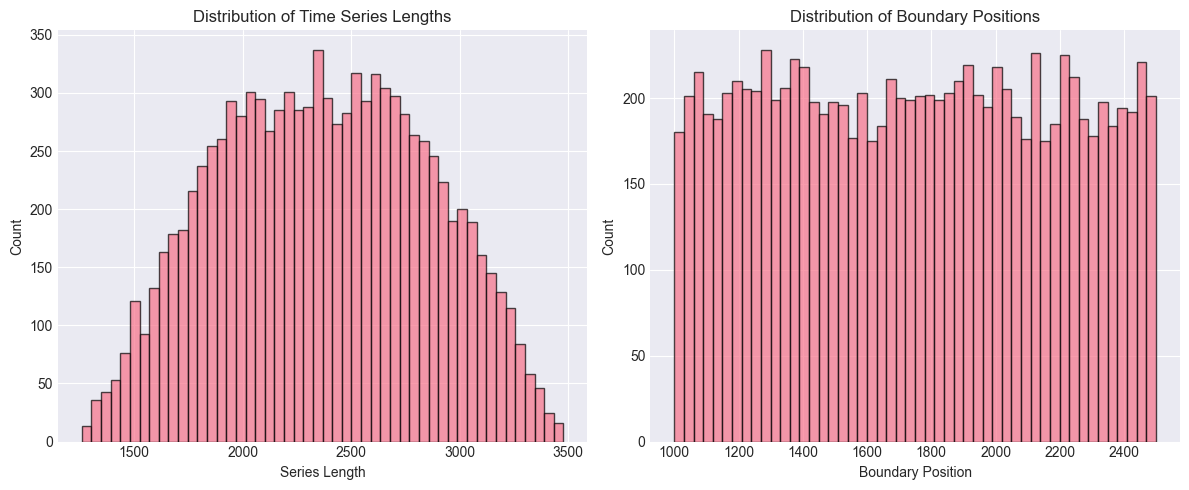

In [6]:
# Plot length distribution
lengths = [ts.length for ts in loader.get_all_train_series().values()]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(lengths, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Series Length')
plt.ylabel('Count')
plt.title('Distribution of Time Series Lengths')

# Boundary position distribution
boundaries = [ts.boundary_point for ts in loader.get_all_train_series().values()]
plt.subplot(1, 2, 2)
plt.hist(boundaries, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Boundary Position')
plt.ylabel('Count')
plt.title('Distribution of Boundary Positions')
plt.tight_layout()
plt.show()

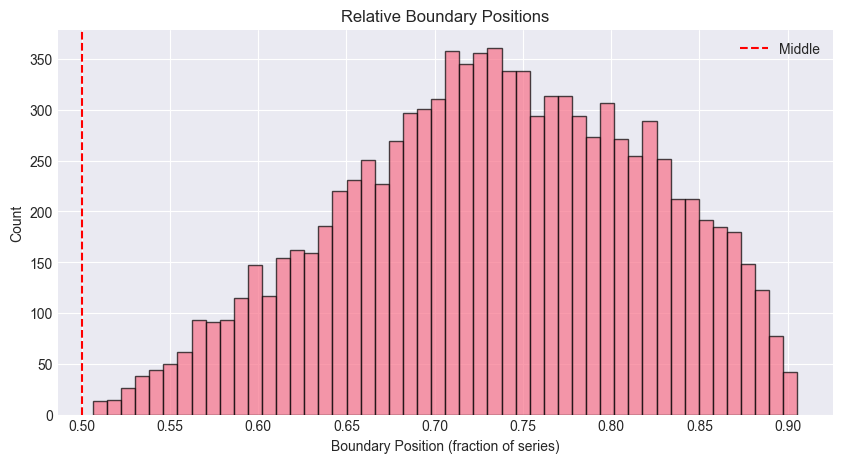

Mean boundary fraction: 0.734
Std boundary fraction: 0.086


In [7]:
# Analyze boundary position as fraction of series length
boundary_fractions = [ts.boundary_point / ts.length for ts in loader.get_all_train_series().values()]

plt.figure(figsize=(10, 5))
plt.hist(boundary_fractions, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Boundary Position (fraction of series)')
plt.ylabel('Count')
plt.title('Relative Boundary Positions')
plt.axvline(x=0.5, color='red', linestyle='--', label='Middle')
plt.legend()
plt.show()

print(f"Mean boundary fraction: {np.mean(boundary_fractions):.3f}")
print(f"Std boundary fraction: {np.std(boundary_fractions):.3f}")

4. Visualize Example Series

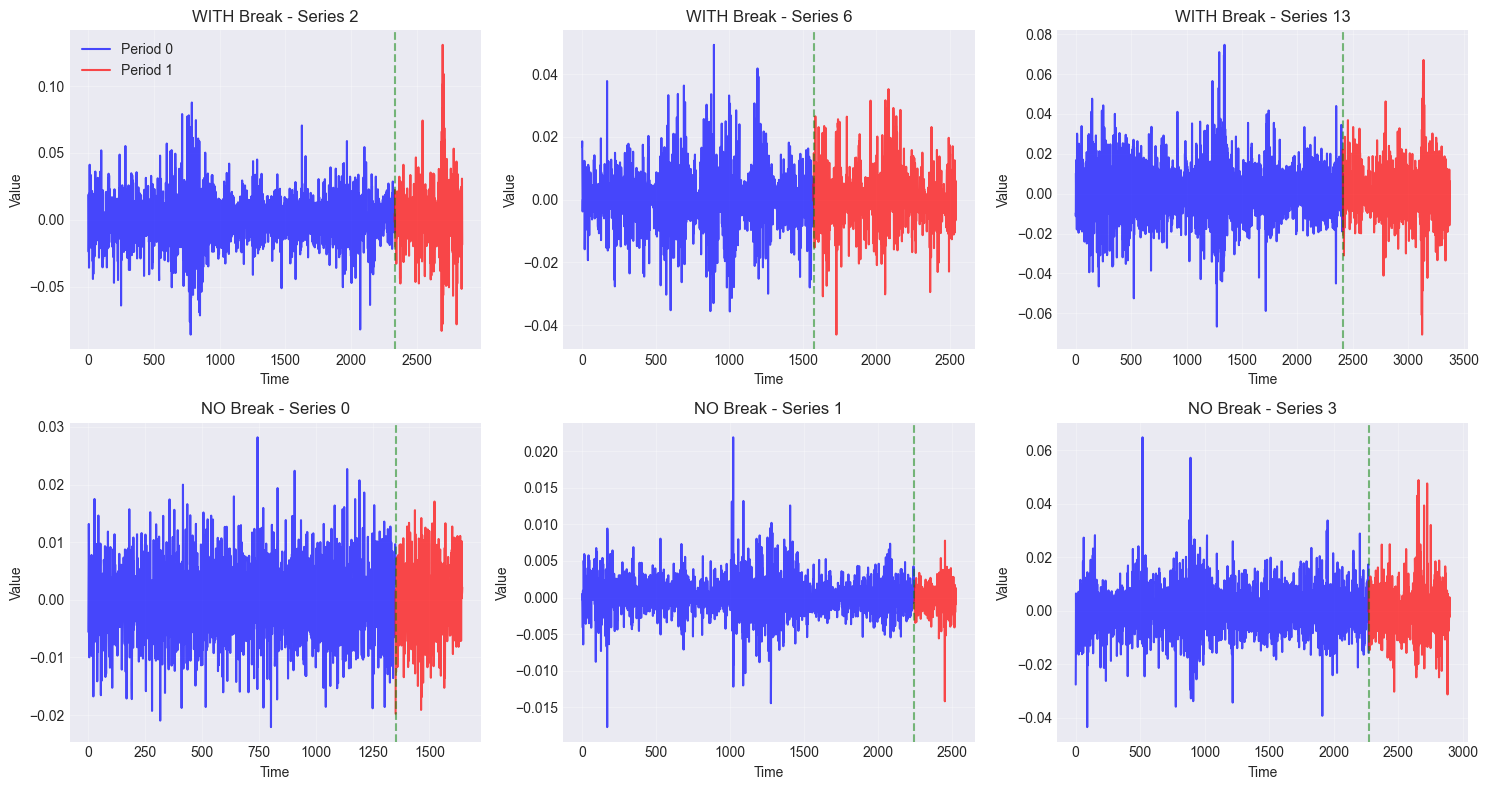

In [8]:
# Plot examples of series with and without breaks
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Get positive and negative examples
positive_examples = loader.get_positive_examples()
negative_examples = loader.get_negative_examples()

# Plot 3 positive examples
for i, (series_id, ts_data) in enumerate(list(positive_examples.items())[:3]):
    ax = axes[i]
    
    # Create time array
    time = np.arange(ts_data.length)
    
    # Plot with different colors for periods
    mask_p0 = time < ts_data.boundary_point
    mask_p1 = time >= ts_data.boundary_point
    
    ax.plot(time[mask_p0], ts_data.values[mask_p0], 'b-', label='Period 0', alpha=0.7)
    ax.plot(time[mask_p1], ts_data.values[mask_p1], 'r-', label='Period 1', alpha=0.7)
    ax.axvline(x=ts_data.boundary_point, color='green', linestyle='--', alpha=0.5)
    
    ax.set_title(f'WITH Break - Series {series_id}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend()

# Plot 3 negative examples  
for i, (series_id, ts_data) in enumerate(list(negative_examples.items())[:3]):
    ax = axes[i + 3]
    
    time = np.arange(ts_data.length)
    mask_p0 = time < ts_data.boundary_point
    mask_p1 = time >= ts_data.boundary_point
    
    ax.plot(time[mask_p0], ts_data.values[mask_p0], 'b-', label='Period 0', alpha=0.7)
    ax.plot(time[mask_p1], ts_data.values[mask_p1], 'r-', label='Period 1', alpha=0.7)
    ax.axvline(x=ts_data.boundary_point, color='green', linestyle='--', alpha=0.5)
    
    ax.set_title(f'NO Break - Series {series_id}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

5. Statistical Analysis of Breaks

In [9]:
# Analyze different types of structural breaks
def analyze_break_types(loader):
    """Analyze what changes between periods"""
    
    positive_examples = loader.get_positive_examples()
    negative_examples = loader.get_negative_examples()
    
    # Statistics to collect
    mean_changes_pos = []
    std_changes_pos = []
    mean_changes_neg = []
    std_changes_neg = []
    
    # For positive examples
    for series_id, ts_data in positive_examples.items():
        p0_mean = np.mean(ts_data.period_0_values)
        p1_mean = np.mean(ts_data.period_1_values)
        p0_std = np.std(ts_data.period_0_values)
        p1_std = np.std(ts_data.period_1_values)
        
        mean_changes_pos.append(p1_mean - p0_mean)
        std_changes_pos.append(p1_std - p0_std)
    
    # For negative examples
    for series_id, ts_data in negative_examples.items():
        p0_mean = np.mean(ts_data.period_0_values)
        p1_mean = np.mean(ts_data.period_1_values)
        p0_std = np.std(ts_data.period_0_values)
        p1_std = np.std(ts_data.period_1_values)
        
        mean_changes_neg.append(p1_mean - p0_mean)
        std_changes_neg.append(p1_std - p0_std)
    
    return {
        'mean_changes_pos': mean_changes_pos,
        'std_changes_pos': std_changes_pos,
        'mean_changes_neg': mean_changes_neg,
        'std_changes_neg': std_changes_neg
    }

break_analysis = analyze_break_types(loader)

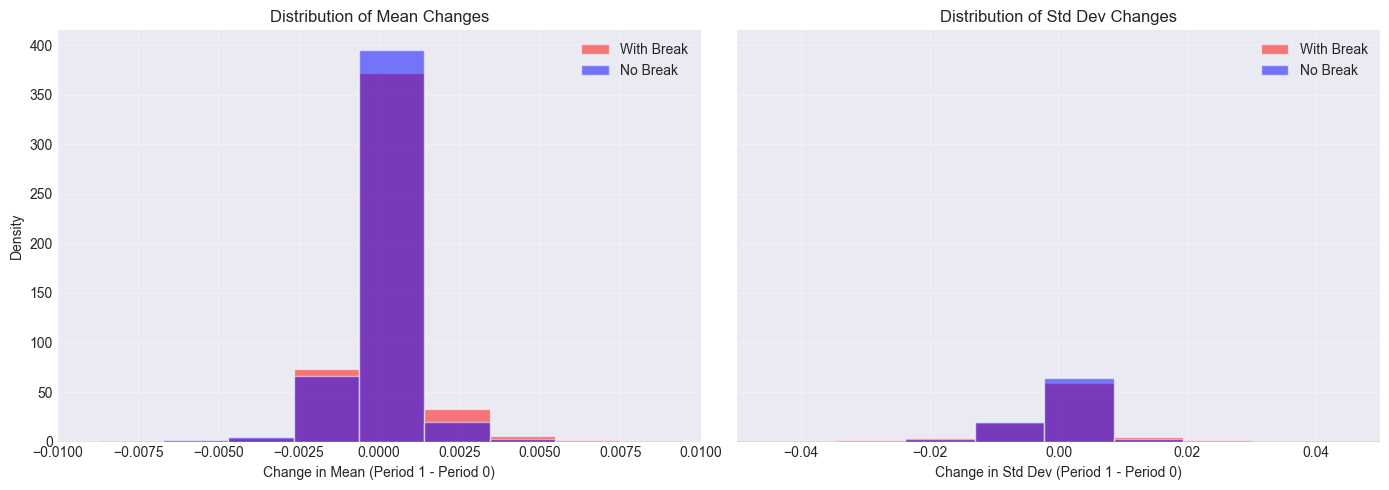

In [44]:
# Mean changes bins (you already have this)
all_mean = np.concatenate([break_analysis['mean_changes_pos'],
                           break_analysis['mean_changes_neg']])
mean_min, mean_max = all_mean.min(), all_mean.max()
mean_bin_edges = np.linspace(mean_min, mean_max, 301)  # 300 bins

# Std changes bins
all_std = np.concatenate([break_analysis['std_changes_pos'],
                          break_analysis['std_changes_neg']])
std_min, std_max = all_std.min(), all_std.max()
std_bin_edges = np.linspace(std_min, std_max, 1001)  # e.g. 200 bins

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Mean changes
ax1.hist(break_analysis['mean_changes_pos'], bins=mean_bin_edges, alpha=0.5,
         label='With Break', density=True, color='red')
ax1.hist(break_analysis['mean_changes_neg'], bins=mean_bin_edges, alpha=0.5,
         label='No Break', density=True, color='blue')
ax1.set_xlabel('Change in Mean (Period 1 - Period 0)')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of Mean Changes')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-0.01, 0.01)  # or use [mean_min, mean_max] if you prefer

# Std changes
ax2.hist(break_analysis['std_changes_pos'], bins=std_bin_edges, alpha=0.5,
         label='With Break', density=True, color='red')
ax2.hist(break_analysis['std_changes_neg'], bins=std_bin_edges, alpha=0.5,
         label='No Break', density=True, color='blue')
ax2.set_xlabel('Change in Std Dev (Period 1 - Period 0)')
ax2.set_title('Distribution of Std Dev Changes')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-0.05, 0.05)  # or [std_min, std_max] or a symmetric range based on max abs

plt.tight_layout()
plt.show()


6. Feature Engineering Ideas

In [13]:
# Test various statistical tests for break detection
def test_statistical_methods(ts_data):
    """Apply various statistical tests to detect breaks"""
    
    results = {}
    
    # T-test for mean difference
    t_stat, t_pvalue = st.ttest_ind(ts_data.period_0_values, ts_data.period_1_values)
    results['ttest_pvalue'] = t_pvalue
    
    # Mann-Whitney U test (non-parametric)
    u_stat, u_pvalue = st.mannwhitneyu(ts_data.period_0_values, ts_data.period_1_values)
    results['mannwhitney_pvalue'] = u_pvalue
    
    # Levene test for variance
    lev_stat, lev_pvalue = st.levene(ts_data.period_0_values, ts_data.period_1_values)
    results['levene_pvalue'] = lev_pvalue
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_pvalue = st.ks_2samp(ts_data.period_0_values, ts_data.period_1_values)
    results['ks_pvalue'] = ks_pvalue
    
    return results

In [16]:
# Apply tests to a sample of series
sample_size = 1000
positive_sample = list(loader.get_positive_examples().items())[:sample_size]
negative_sample = list(loader.get_negative_examples().items())[:sample_size]

# Collect p-values
test_results_pos = []
test_results_neg = []

for series_id, ts_data in positive_sample:
    test_results_pos.append(test_statistical_methods(ts_data))
    
for series_id, ts_data in negative_sample:
    test_results_neg.append(test_statistical_methods(ts_data))

# Convert to DataFrames
df_pos = pd.DataFrame(test_results_pos)
df_neg = pd.DataFrame(test_results_neg)

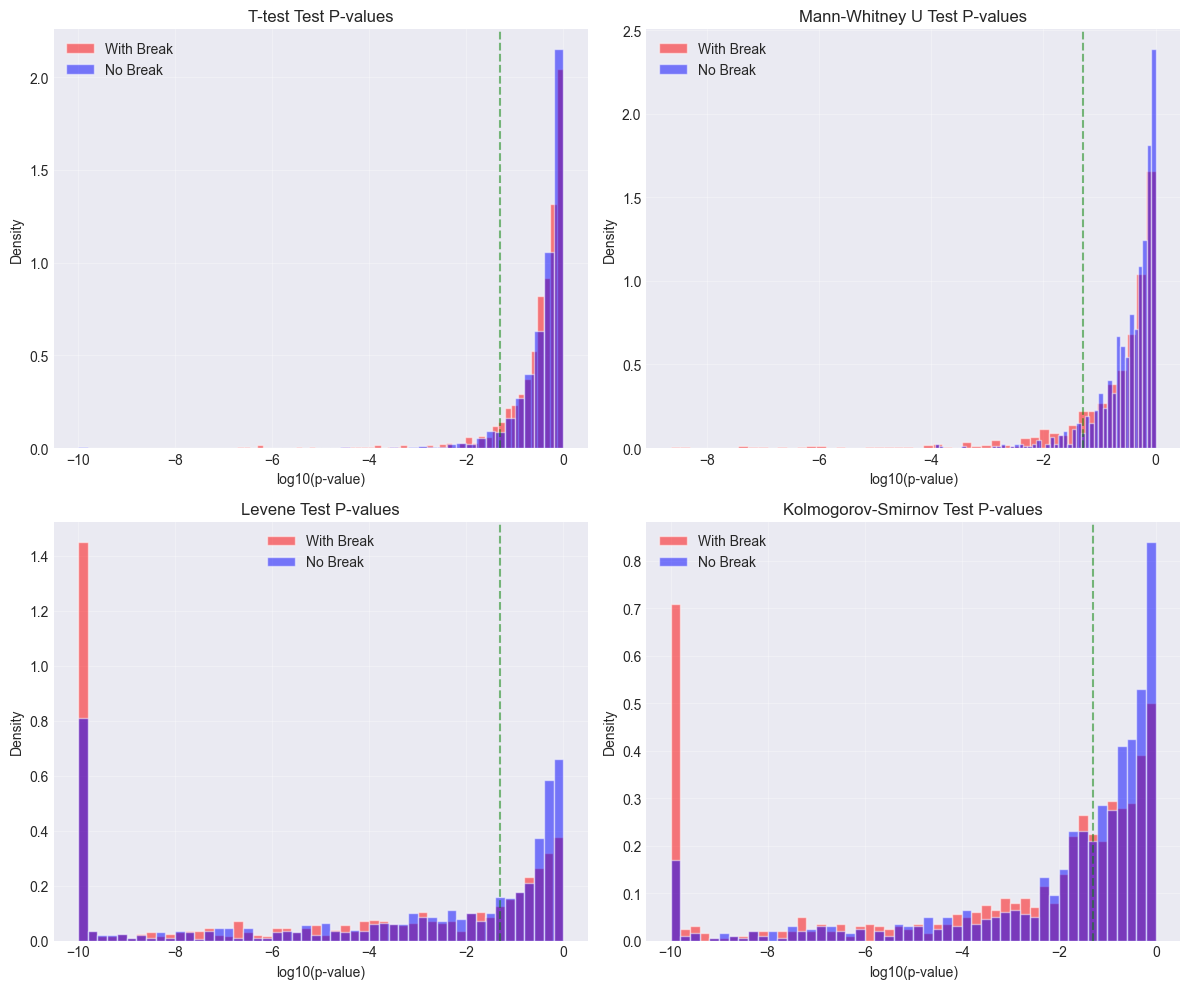

In [47]:
# Plot p-value distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

tests = ['ttest_pvalue', 'mannwhitney_pvalue', 'levene_pvalue', 'ks_pvalue']
test_names = ['T-test', 'Mann-Whitney U', 'Levene', 'Kolmogorov-Smirnov']

for i, (test, name) in enumerate(zip(tests, test_names)):
    ax = axes[i]
    
    # Plot on log scale
    ax.hist(np.log10(df_pos[test] + 1e-10), bins=50, alpha=0.5, label='With Break', density=True, color='red')
    ax.hist(np.log10(df_neg[test] + 1e-10), bins=50, alpha=0.5, label='No Break', density=True, color='blue')
    
    ax.set_xlabel('log10(p-value)')
    ax.set_ylabel('Density')
    ax.set_title(f'{name} Test P-values')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add significance line
    ax.axvline(x=np.log10(0.05), color='green', linestyle='--', alpha=0.5, label='p=0.05')

plt.tight_layout()
plt.show()

7. Advanced Feature Ideas

In [18]:
# Additional feature engineering ideas to explore:

print("Advanced Feature Engineering Ideas:\n")

print("1. Time Series Features:")
print("   - Autocorrelation differences between periods")
print("   - Spectral density changes")
print("   - Hurst exponent")
print("   - Approximate entropy")
print("   - Detrended fluctuation analysis")

print("\n2. Change Point Detection Methods:")
print("   - CUSUM (Cumulative Sum)")
print("   - Binary Segmentation")
print("   - PELT (Pruned Exact Linear Time)")
print("   - Bayesian Change Point Detection")

print("\n3. Machine Learning Features:")
print("   - Rolling window statistics")
print("   - Wavelet coefficients")
print("   - Recurrence quantification analysis")
print("   - Symbolic dynamics")

print("\n4. Deep Learning Approaches:")
print("   - LSTM autoencoders for anomaly detection")
print("   - CNN for pattern recognition")
print("   - Attention mechanisms for change detection")

Advanced Feature Engineering Ideas:

1. Time Series Features:
   - Autocorrelation differences between periods
   - Spectral density changes
   - Hurst exponent
   - Approximate entropy
   - Detrended fluctuation analysis

2. Change Point Detection Methods:
   - CUSUM (Cumulative Sum)
   - Binary Segmentation
   - PELT (Pruned Exact Linear Time)
   - Bayesian Change Point Detection

3. Machine Learning Features:
   - Rolling window statistics
   - Wavelet coefficients
   - Recurrence quantification analysis
   - Symbolic dynamics

4. Deep Learning Approaches:
   - LSTM autoencoders for anomaly detection
   - CNN for pattern recognition
   - Attention mechanisms for change detection


8. Next Steps

In [19]:
print("Next Steps for Model Development:\n")

print("1. Feature Engineering:")
print("   - Implement the statistical tests as features")
print("   - Add time series complexity measures")
print("   - Create rolling window features")
print("   - Engineer interaction features")

print("\n2. Model Selection:")
print("   - Start with XGBoost/LightGBM as baseline")
print("   - Try ensemble methods")
print("   - Experiment with neural networks")
print("   - Consider model stacking")

print("\n3. Validation Strategy:")
print("   - Use stratified k-fold cross-validation")
print("   - Monitor for overfitting")
print("   - Analyze false positives/negatives")
print("   - Check performance on different break types")

print("\n4. Optimization:")
print("   - Hyperparameter tuning")
print("   - Feature selection")
print("   - Threshold optimization for ROC AUC")

Next Steps for Model Development:

1. Feature Engineering:
   - Implement the statistical tests as features
   - Add time series complexity measures
   - Create rolling window features
   - Engineer interaction features

2. Model Selection:
   - Start with XGBoost/LightGBM as baseline
   - Try ensemble methods
   - Experiment with neural networks
   - Consider model stacking

3. Validation Strategy:
   - Use stratified k-fold cross-validation
   - Monitor for overfitting
   - Analyze false positives/negatives
   - Check performance on different break types

4. Optimization:
   - Hyperparameter tuning
   - Feature selection
   - Threshold optimization for ROC AUC


In [20]:
# Save processed data for faster loading
loader.save_processed_data('../data/processed_data.pkl')
print("Processed data saved for faster loading in future runs!")

INFO:src.data.dataLoader:Processed data saved to ../data/processed_data.pkl


Processed data saved for faster loading in future runs!
